In [1]:
import networkx as nx
import random

import numpy as np

In [2]:
class NodesAttributes:
    '''
    Provides important nodes attributes that can be used for community search
    '''
    def __init__(self, graph: nx.MultiDiGraph, alpha: float = 0.85) -> None:
        '''
        Initialises nodes attributes for initial graph.
        :param graph: initial graph
        :param alpha: damping factor for PageRank
        '''
        self.graph = graph
        
        self.weighted_digraph = nx.DiGraph(graph)
        for edge in self.weighted_digraph.edges():
            self.weighted_digraph.edges[edge]['weight'] = self.graph.number_of_edges(*edge)

        self.alpha = alpha
        self.pageranks = nx.pagerank(self.graph, alpha=self.alpha)
        self.clusterings = nx.clustering(self.weighted_digraph)

    def update(self, edge_from: int, edge_to: int) -> None:
        '''
        Updates nodes attributes after a step of evolution.
        :param edge_from: source of an edge
        :param edge_to: destination of an edge
        '''
        for node in [edge_from, edge_to]:
            if node not in self.pageranks:
                self.pageranks[node] = (1 - self.alpha) / len(self.graph)

        self.pageranks = nx.pagerank(self.graph, alpha=self.alpha, nstart=self.pageranks)

        if not self.weighted_digraph.has_edge(edge_from, edge_to):
            self.weighted_digraph.add_edge(edge_from, edge_to, weight=0)
        self.weighted_digraph.edges[(edge_from, edge_to)]['weight'] += 1
    
        self.clusterings |= nx.clustering(self.weighted_digraph,
                                          set(self.weighted_digraph.successors(edge_from)) |
                                          set(self.weighted_digraph.successors(edge_to)) |
                                          set(self.weighted_digraph.predecessors(edge_from)) |
                                          set(self.weighted_digraph.predecessors(edge_to)))

    def to_numpy(self) -> None:
        '''
        Constructs numpy array of vectors with nodes attributes
        '''
        return np.array([[self.pageranks[v], self.clusterings[v]] for v in range(len(self.graph))])

In [3]:
class ScaleFreeDiGraph:
    '''
    Scale free digraph, evolving according to alpha-, beta-, gamma- schemas
    '''
    def __init__(self, initial_graph: nx.MultiDiGraph | None = None) -> None:
        '''
        :param initial_graph: initial graph to start with
        '''
        # If initial_graph is None, start with self-loop
        self.graph = initial_graph if initial_graph is not None else nx.MultiDiGraph([(0, 0),])
        
        self._indeg_nodes = sum(([node] * indeg for node, indeg in self.graph.in_degree()), [])
        self._outdeg_nodes = sum(([node] * outdeg for node, outdeg in self.graph.out_degree()), [])
        self._nodes = list(self.graph)
        self._next_node = len(self._nodes)

    def __choose_node(self, deg_nodes: list, nodes: list, delta: float):
        if delta > 0:
            delta_sum = delta * len(nodes)
            delta_prob = delta_sum / (len(deg_nodes) + delta_sum)
            if random.random() < delta_prob:
                return random.choice(nodes)
        return random.choice(deg_nodes)

    def grow(self, steps: int = 1, alpha: float = 0.41, beta: float = 0.54,
             gamma: float = 0.05, delta_in: float = 0.2, delta_out: float = 0) -> None:
        '''
        Makes specified number of evolution steps
        :param steps: number of evolution steps
        :param alpha: probability for adding new node connected to existing node,
                      chosen according to in-degree distribution
        :param beta: probability for adding new edge between existing nodes,
                     which are chosen according to in- and out-degree distributions
        :param gamma: probability for adding new node connected to existing node,
                      chosen according to out-degree distribution
        :param delta_in: bias for choosing nodes from in-degree distribution
        :param delta_out: bias for choosing nodes from out-degree distribution
        '''
        if alpha < 0:
            raise ValueError("alpha must be >= 0")
        if beta < 0:
            raise ValueError("beta must be >= 0")
        if gamma < 0:
            raise ValueError("gamma must be >= 0")
    
        if abs(alpha + beta + gamma - 1.0) >= 1e-9:
            raise ValueError("alpha+beta+gamma must equal 1")
    
        if delta_in < 0:
            raise ValueError("delta_in must be >= 0.")
        if delta_out < 0:
            raise ValueError("delta_out must be >= 0.")

        for step in range(steps):
            coin = random.random()

            if coin < alpha:
                node_from = self._next_node
                node_to = self.__choose_node(self._indeg_nodes, self._nodes, delta_in)
                
                self._nodes.append(self._next_node)
                self._next_node += 1
            elif coin < alpha + beta:
                node_from = self.__choose_node(self._outdeg_nodes, self._nodes, delta_out)
                node_to = self.__choose_node(self._indeg_nodes, self._nodes, delta_in)
            else:
                node_from = self.__choose_node(self._outdeg_nodes, self._nodes, delta_out)
                node_to = self._next_node

                self._nodes.append(self._next_node)
                self._next_node += 1

            self.graph.add_edge(node_from, node_to)
            self._indeg_nodes.append(node_to)
            self._outdeg_nodes.append(node_from)

In [4]:
import matplotlib.pyplot as plt

In [23]:
%%time

scale_free = ScaleFreeDiGraph()
scale_free.grow(10000, alpha=0.3, beta=0.4, gamma=0.3)

CPU times: user 35.1 ms, sys: 35.3 ms, total: 70.5 ms
Wall time: 211 ms


In [24]:
attributes = NodesAttributes(scale_free.graph)
data = attributes.to_numpy()

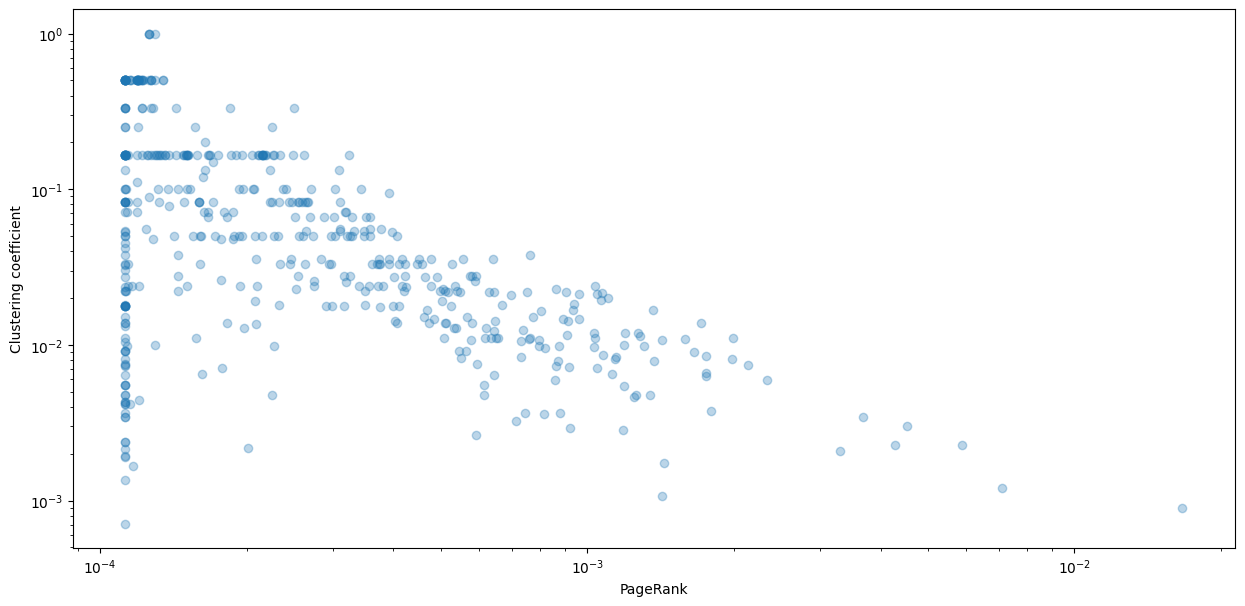

In [25]:
plt.figure(figsize=(15, 7))

plt.xlabel('PageRank')
plt.ylabel('Clustering coefficient')
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.3)

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0, 0.0002))
# plt.ylim((0, 0.1))

plt.show()

In [ ]:
scale_free.grow(10000, alpha=0.3, beta=0.4, gamma=0.3)

In [14]:
%%time

scale_free = ScaleFreeDiGraph(initial_graph=init_graph)
scale_free.grow(10000, alpha=0.3, beta=0.4, gamma=0.3)

CPU times: user 30.5 ms, sys: 7.94 ms, total: 38.4 ms
Wall time: 37.7 ms


CPU times: user 31.7 s, sys: 98.1 ms, total: 31.8 s
Wall time: 31 s


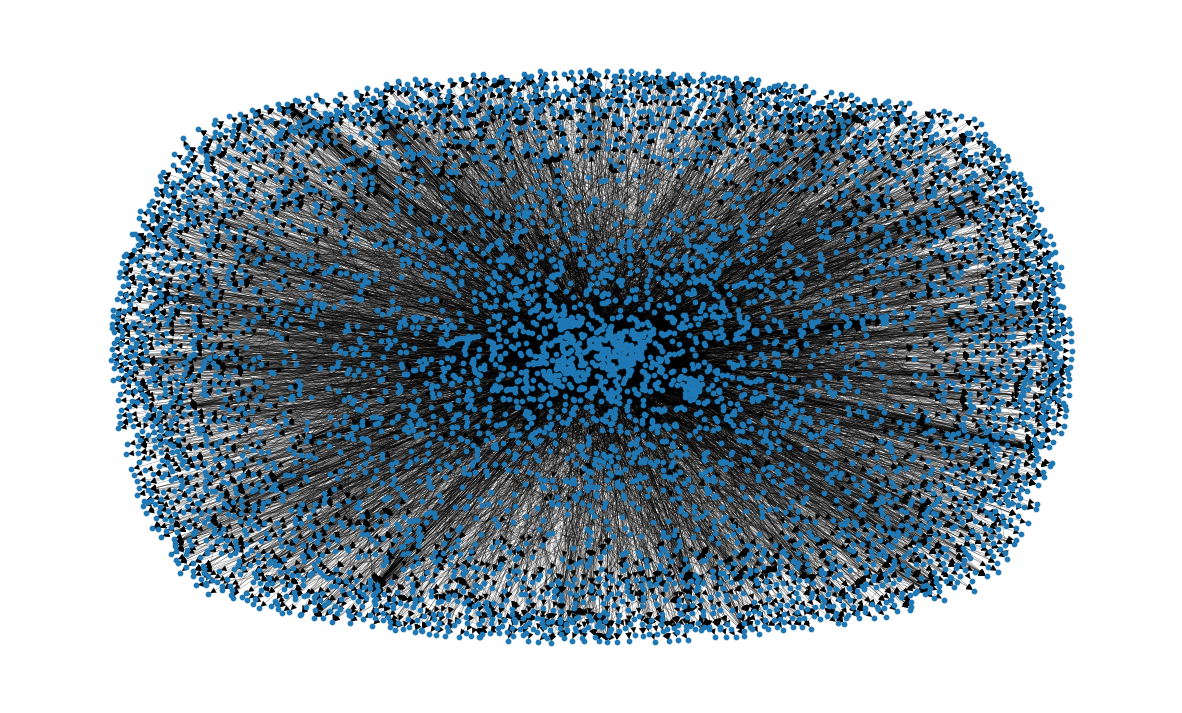

In [15]:
%%time

fig, ax = plt.subplots(figsize=(15, 9))
pos = nx.spring_layout(scale_free.graph, iterations=15, seed=1720)
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(scale_free.graph, pos=pos, ax=ax, **plot_options)

In [17]:
attributes = NodesAttributes(scale_free.graph)
data = attributes.to_numpy()

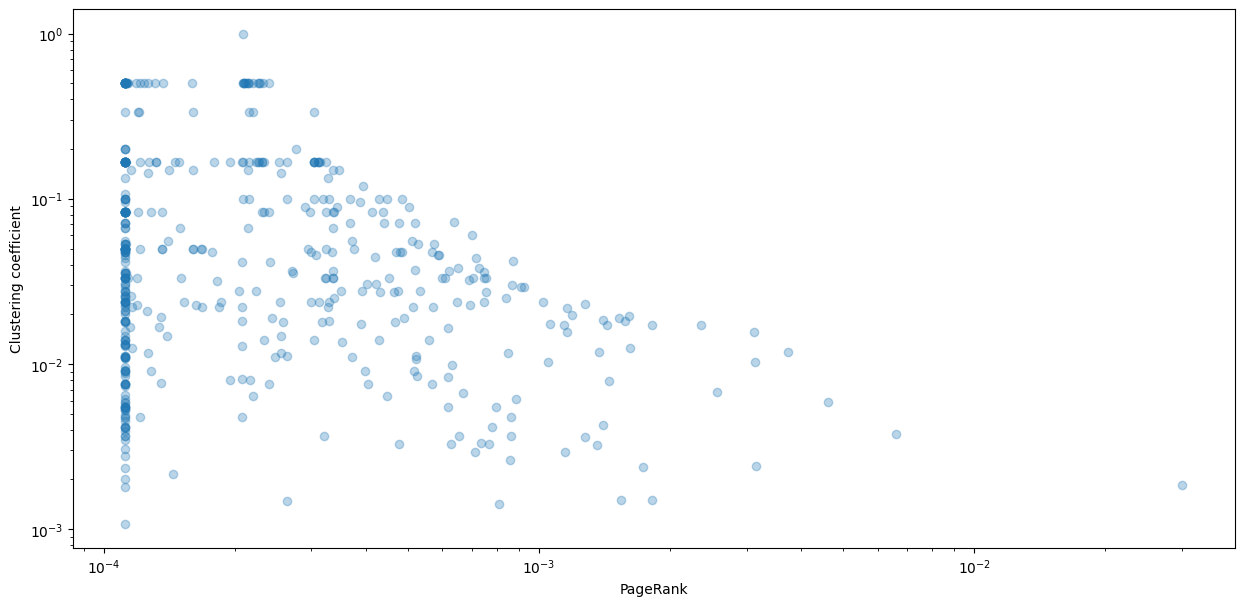

In [19]:
plt.figure(figsize=(15, 7))

plt.xlabel('PageRank')
plt.ylabel('Clustering coefficient')
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.3)

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0, 0.0002))
# plt.ylim((0, 0.1))

plt.show()

In [5]:
from embeddings import PageRankInDegree

In [6]:
%%time

scale_free = ScaleFreeDiGraph()
scale_free.grow(10000, alpha=0.3, beta=0.4, gamma=0.3)

CPU times: user 206 ms, sys: 236 ms, total: 442 ms
Wall time: 966 ms


In [20]:
attributes = PageRankInDegree(scale_free.graph)
data = attributes.to_numpy()

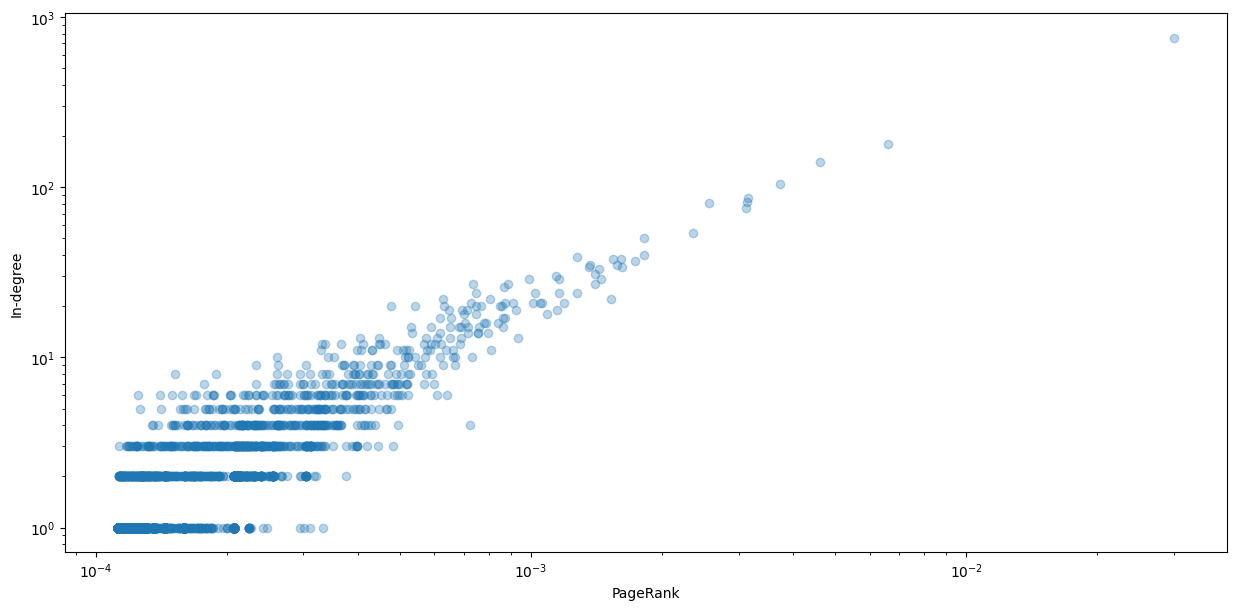

In [22]:
plt.figure(figsize=(15, 7))

plt.xlabel('PageRank')
plt.ylabel('In-degree')
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.3)

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0, 0.0002))
# plt.ylim((0, 0.1))

plt.show()

In [11]:
new_data = [tuple(row) for row in data]

In [12]:
from collections import Counter


cnt = Counter(new_data)

In [13]:
cnt

Counter({(np.float64(0.00011213224760787954), np.float64(0.0)): 2519,
         (np.float64(0.0001598798784384262), np.float64(1.0)): 180,
         (np.float64(0.00014396400149491067), np.float64(1.0)): 135,
         (np.float64(0.00011258707565875653), np.float64(1.0)): 121,
         (np.float64(0.00013600606302315287), np.float64(1.0)): 118,
         (np.float64(0.00013123129994009822), np.float64(1.0)): 73,
         (np.float64(0.0001280481245513951), np.float64(1.0)): 68,
         (np.float64(0.00012577442784517858), np.float64(1.0)): 64,
         (np.float64(0.00011247452453139599), np.float64(1.0)): 62,
         (np.float64(0.00020802241167476931), np.float64(1.0)): 56,
         (np.float64(0.00020762750926897288), np.float64(1.0)): 51,
         (np.float64(0.00011252523222376879), np.float64(1.0)): 50,
         (np.float64(0.00011269069943045903), np.float64(1.0)): 37,
         (np.float64(0.00011947803696642518), np.float64(1.0)): 37,
         (np.float64(0.00011502604341579145)

In [15]:
scaled = (data - data.mean(axis=0, keepdims=True)) / data.std(axis=0, keepdims=True)

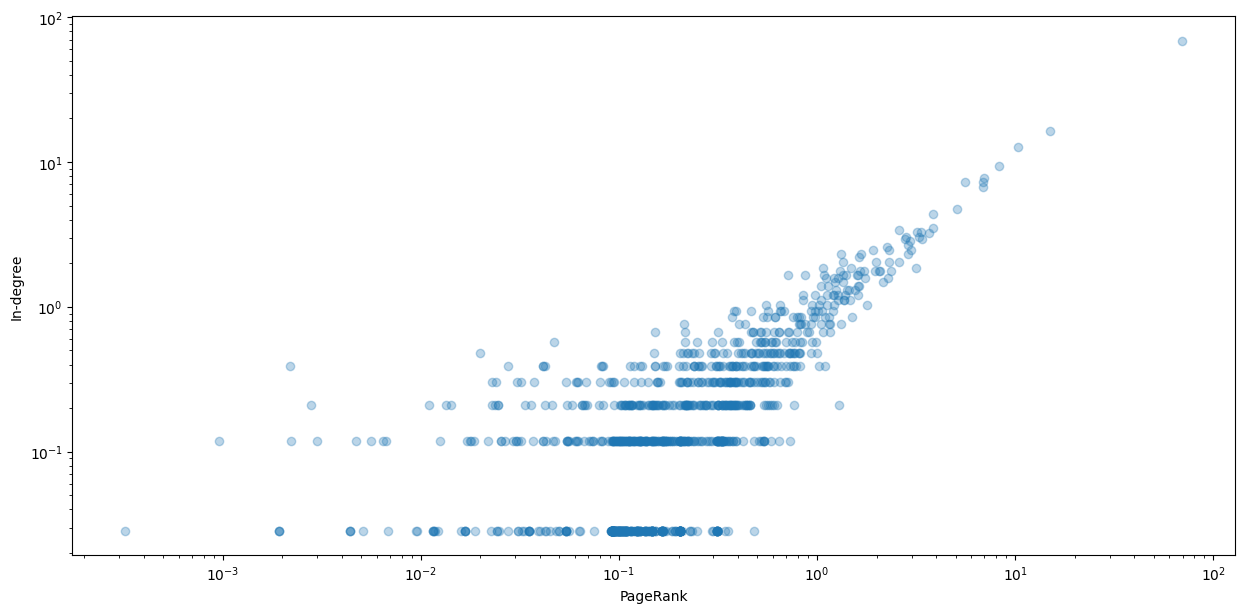

In [16]:
plt.figure(figsize=(15, 7))

plt.xlabel('PageRank')
plt.ylabel('In-degree')
plt.scatter(x=scaled[:, 0], y=scaled[:, 1], alpha=0.3)

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0, 0.0002))
# plt.ylim((0, 0.1))

plt.show()